In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys                                                                              
np.random.seed(1)                                                                       
import tensorflow as tf                                                                 
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential                             
from tensorflow.keras.layers import Dense, LSTM , Dropout, BatchNormalization                                     
from tensorflow.keras.optimizers import Adam                                           
from tensorflow.keras.callbacks import EarlyStopping                                   
from sklearn.preprocessing import MinMaxScaler                                          
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error  
from math import sqrt
from keras import optimizers
import datetime as dt
from datetime import date,datetime
import time
plt.style.use('ggplot')                                                                 

In [35]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=80,  verbose=1, mode='min')  
callbacks_list = [earlystop]                                                                          # 

In [36]:
data = pd.read_csv('D:\Đồ án TN\sentiment_score.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

In [37]:
def fit_model_LSTM(train, val, timesteps, hl, lr, batch, epochs):
    # np.random.seed(1)
    # tf.random.set_seed(2)

    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Chuẩn bị dữ liệu cho tập train
    for i in range(timesteps, train.shape[0]):  
        X_train.append(train[i-timesteps:i])  
        Y_train.append(train[i][0])  
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Chuẩn bị dữ liệu cho tập validation
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xác định số đặc trưng
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Xây dựng model
    model = Sequential()
    model.add(LSTM(hl[0], input_shape=input_shape, activation='relu', return_sequences=True))
    # model.add(Dropout(0.2))
    for i in range(1, len(hl)-1):  
        model.add(LSTM(hl[i], activation='relu', return_sequences=True))  
        # model.add(Dropout(0.2))
    model.add(LSTM(hl[-1], activation='relu', return_sequences=False))
    model.add(Dense(1))  

    # Biên dịch mô hình
    model.compile(optimizers.Adam(learning_rate=lr), loss='mean_squared_error')

    # Thêm callback để tránh overfitting
    callbacks_list = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, 
                        validation_data=(X_val, Y_val), verbose=1, shuffle=False,
                        callbacks=callbacks_list)

    return model, history.history['loss'], history.history['val_loss']

In [38]:
def evaluate_model(model, test, timesteps,sc):
    # np.random.seed(1)
    # tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)   
    Y_test_inv = np.exp(sc.inverse_transform(np.concatenate([Y_test.reshape(-1, 1), 
                                                  np.zeros((Y_test.shape[0], test.shape[1]-1))], axis=1))[:,0])
    Y_hat_inv = np.exp(sc.inverse_transform(np.concatenate([Y_hat.reshape(-1, 1), 
                                                 np.zeros((Y_hat.shape[0], test.shape[1]-1))], axis=1))[:,0])                  
    mse = mean_squared_error(Y_test_inv, Y_hat_inv)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test_inv, Y_hat_inv)
    mae = np.mean(np.abs(Y_test_inv - Y_hat_inv))
    r2 = r2_score(Y_test_inv, Y_hat_inv)
    return mse, rmse, mape,mae, r2, Y_test_inv, Y_hat_inv

In [39]:
# Plotting the predictions: vẽ y_test và y_hat -> trực quan hoá kqua
def plot_data_LSTM(Y_test, Y_hat):
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test, c = 'r')                                 #test màu đỏ
    plt.plot(Y_hat, c = 'y')                                  #dự đoán màu vàng
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using LSTM")
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()  

In [40]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.figure(figsize=(14, 6))
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

In [41]:
# Ngày bắt đầu và tổng số ngày
start_date = dt.date(2020, 3, 8)
end_date = dt.date(2025, 5, 5)
total_days = (end_date - start_date).days + 1  # Đếm cả ngày cuối cùng


train_days = int(total_days * 0.7)
val_days = int(total_days * 0.15)
test_days = total_days - train_days - val_days  # Phần còn lại cho test

# Xác định ngày kết thúc cho từng tập
train_end = start_date + dt.timedelta(days=train_days - 1)
val_end = train_end + dt.timedelta(days=val_days)



In [42]:
# # Chia dữ liệu thành train, val, test (80% train, 10% validation, 10% test)
# train_size = int(len(data) * 0.7)
# val_size = int(len(data) * 0.15)
# test_size = len(data) - train_size - val_size

# train = data.iloc[:train_size]
# val = data.iloc[train_size:train_size + val_size]
# test = data.iloc[train_size + val_size:]

LSTM

In [43]:
data['close'] = np.log(data[['close']])
series = data[['close']]
# Lấy dữ liệu
train_data = series.loc[start_date:train_end]
val_data = series.loc[train_end + dt.timedelta(days=1):val_end]
test_data = series.loc[val_end + dt.timedelta(days=1):]

print(train_data.shape, val_data.shape, test_data.shape)

(1309, 1) (282, 1) (284, 1)


In [44]:

sc = MinMaxScaler() #thu nhỏ về khoảng [0,1]
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape, val.shape, test.shape)

(1309, 1) (282, 1) (284, 1)


In [45]:
timesteps = 15
hl = [40,30]      
lr = 1e-3     
batch_size = 64
num_epochs = 100

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.3668 - val_loss: 0.0430
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0386 - val_loss: 0.0034
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0120 - val_loss: 0.0036
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

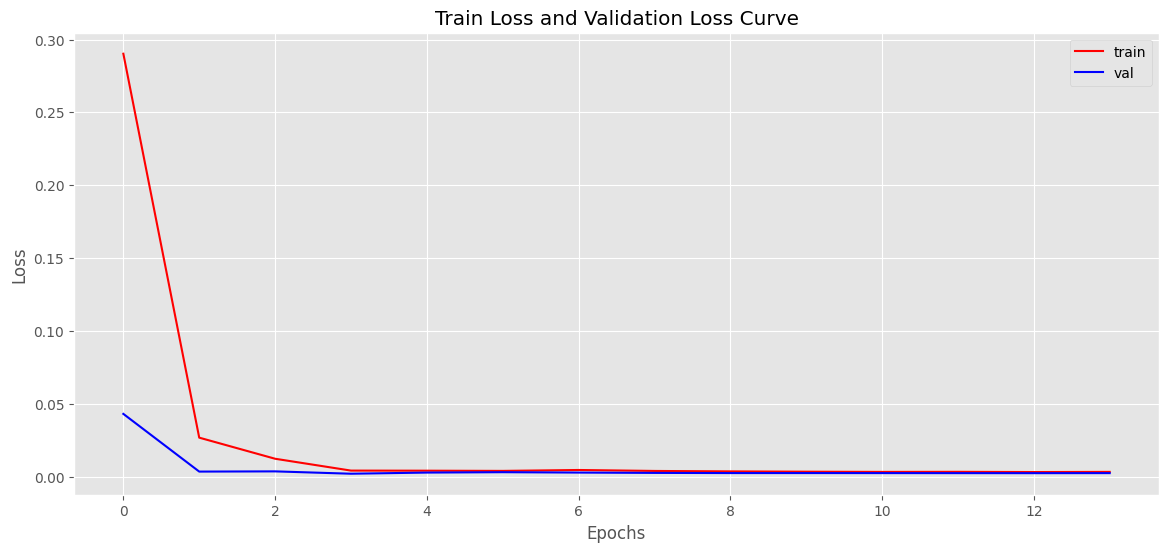

In [46]:
model, train_error, val_error = fit_model_LSTM(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
MSE = 2.9735366016767637
RMSE = 1.7243945609044247
MAPE = 0.031854154162072976
MAE = 1.3384215298754423
R-Squared Score = 0.8233360320590426


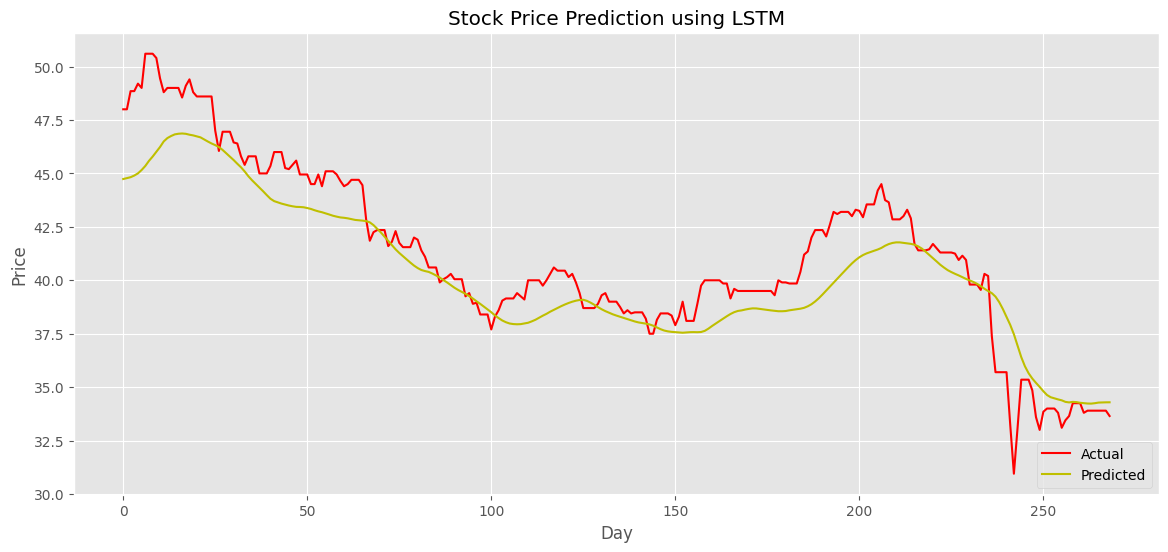

In [47]:
mse, rmse, mape, mae, r2, true, predicted = evaluate_model(model, test, timesteps,sc) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('MAE = {}'.format(mae))
print('R-Squared Score = {}'.format(r2))
plot_data_LSTM(true, predicted)


TIMESNET

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [49]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True  # đảm bảo kết quả tái lập
    torch.backends.cudnn.benchmark = False     # tắt auto-tuning để ổn định kết quả


In [50]:
set_seed(42)
seq_len = 30
pred_len = 1
# Tải dữ liệu và tiền xử lý
data = pd.read_csv('D:\Đồ án TN\sentiment_score.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data = data[['close']]
data['close'] = np.log(data['close'])
# data['volume'] = np.log(data['volume'] + 1)  
data.fillna(0, inplace=True) 

In [51]:
#Chuẩn hóa dữ liệu đầu vào
scaler = MinMaxScaler()
data[['close']] = scaler.fit_transform(data[['close']])
# Chia dữ liệu thành tập huấn luyện, tập xác thực và tập kiểm tra
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train = data.iloc[:train_size]
val = data.iloc[train_size:train_size + val_size]
test = data.iloc[train_size + val_size:]

In [52]:
#Hàm tạo sequence
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data.iloc[i:i+seq_len].values)  
        y.append(data.iloc[i+seq_len:i+seq_len+pred_len, 0])  
    return np.array(X), np.array(y)
# Tạo sequences cho các tập train, val, test
X_train, y_train = create_sequences(train, seq_len, pred_len)
X_val, y_val = create_sequences(val, seq_len, pred_len)
X_test, y_test = create_sequences(test, seq_len, pred_len)
# Convert dữ liệu sang tensor và thêm chiều cuối cho phù hợp với output model
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# In ra kích thước của các tập dữ liệu
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: torch.Size([1282, 30, 1]), torch.Size([1282, 1, 1])
Val: torch.Size([251, 30, 1]), torch.Size([251, 1, 1])
Test: torch.Size([252, 30, 1]), torch.Size([252, 1, 1])


In [53]:
# Mô hình TimesNet
import torch
import torch.nn as nn

class TimesBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, dilation_base, dropout):
        super(TimesBlock, self).__init__()
        padding = ((kernel_size - 1) * dilation_base) // 2
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size,
                               padding=padding, dilation=dilation_base)
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size,
                               padding=padding, dilation=dilation_base)
        self.norm = nn.LayerNorm(in_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):  
        residual = x
        x = x.permute(0, 2, 1)  
        out = self.conv1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out.permute(0, 2, 1)  
        out = self.norm(out + residual)
        return out


class TimesNet(nn.Module):
    def __init__(self, config):
        super(TimesNet, self).__init__()

        self.input_dim = config["input_dim"]               
        self.hidden_dim = config["hidden_dim"]             
        self.pred_len = config["pred_len"]                 
        self.output_dim = config["output_dim"]             
        self.n_blocks = config["n_blocks"]                 
        self.kernel_size = config["kernel_size"]           
        self.dropout = config.get("dropout", 0.2)          

        self.input_proj = nn.Linear(self.input_dim, self.hidden_dim)
        self.blocks = nn.ModuleList([
            TimesBlock(self.hidden_dim, self.kernel_size, dilation_base=2**i, dropout=self.dropout)
            for i in range(self.n_blocks)
        ])
        self.output_proj = nn.Linear(self.hidden_dim, self.pred_len * self.output_dim)

    def forward(self, x):  
        x = self.input_proj(x)  
        for block in self.blocks:
            x = block(x)
        out = self.output_proj(x[:, -1, :])  
        out = out.view(-1, self.pred_len, self.output_dim)
        return out


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "input_dim": X_train.shape[2],
    "hidden_dim":32,
    "pred_len": pred_len,
    "output_dim": 1,
    "n_blocks": 2,
    "kernel_size": 3,
    "dropout": 0.2,
}

model = TimesNet(config).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.001, weight_decay=1e-3)

# Huấn luyện mô hình
def train_model(model, X_train, y_train, X_val, y_val, loss_fn, optimizer, epochs):
    train_losses = []
    val_losses = []

    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = loss_fn(val_output, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.show()
    return train_losses, val_losses


Epoch 1/100 - Train Loss: 0.3065 - Val Loss: 0.0434
Epoch 2/100 - Train Loss: 0.1539 - Val Loss: 0.0217
Epoch 3/100 - Train Loss: 0.0741 - Val Loss: 0.0523
Epoch 4/100 - Train Loss: 0.0570 - Val Loss: 0.1039
Epoch 5/100 - Train Loss: 0.0717 - Val Loss: 0.1415
Epoch 6/100 - Train Loss: 0.0927 - Val Loss: 0.1500
Epoch 7/100 - Train Loss: 0.0964 - Val Loss: 0.1355
Epoch 8/100 - Train Loss: 0.0860 - Val Loss: 0.1091
Epoch 9/100 - Train Loss: 0.0715 - Val Loss: 0.0797
Epoch 10/100 - Train Loss: 0.0592 - Val Loss: 0.0537
Epoch 11/100 - Train Loss: 0.0488 - Val Loss: 0.0347
Epoch 12/100 - Train Loss: 0.0446 - Val Loss: 0.0230
Epoch 13/100 - Train Loss: 0.0465 - Val Loss: 0.0173
Epoch 14/100 - Train Loss: 0.0512 - Val Loss: 0.0151
Epoch 15/100 - Train Loss: 0.0531 - Val Loss: 0.0143
Epoch 16/100 - Train Loss: 0.0535 - Val Loss: 0.0139
Epoch 17/100 - Train Loss: 0.0524 - Val Loss: 0.0142
Epoch 18/100 - Train Loss: 0.0468 - Val Loss: 0.0158
Epoch 19/100 - Train Loss: 0.0425 - Val Loss: 0.0193
Ep

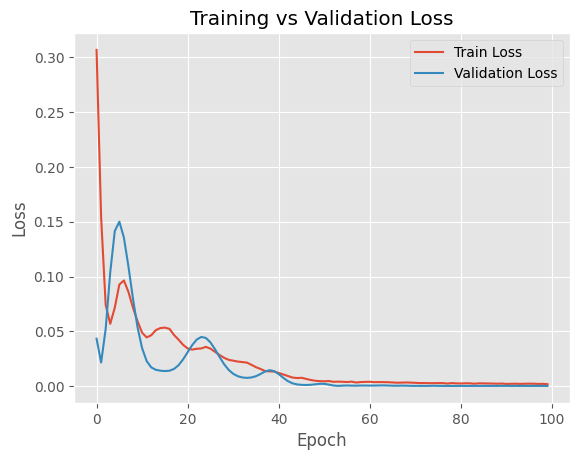

In [55]:
train_losses, val_losses = train_model(
    model, X_train, y_train, X_val, y_val, loss_fn, optimizer,epochs=100
)


RMSE: 0.9458
MAE : 0.7219
MAPE: 0.0179
R²  : 0.9327


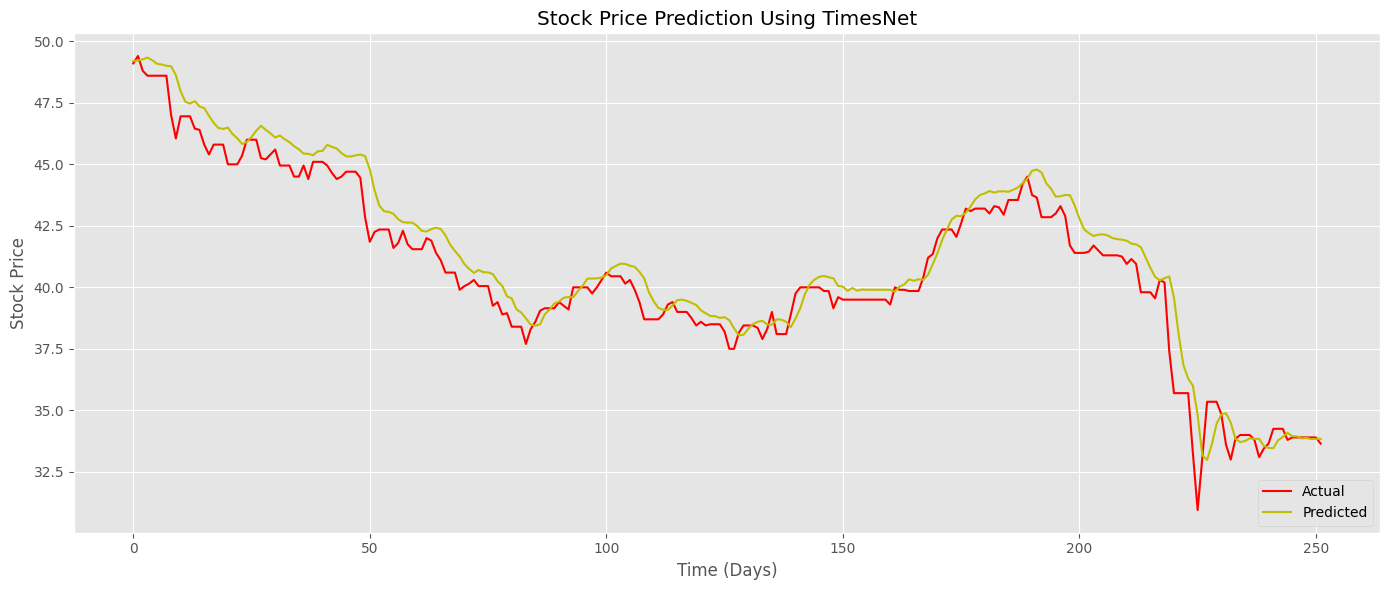

In [56]:
def evaluate(preds, actuals):

    pred_flat = preds.flatten()
    actual_flat = actuals.flatten()

    rmse = mean_squared_error(actual_flat, pred_flat, squared=False)
    mae = mean_absolute_error(actual_flat, pred_flat)
    mape = mean_absolute_percentage_error(actual_flat, pred_flat)
    r2 = r2_score(actual_flat, pred_flat)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²  : {r2:.4f}")
    
model.eval()
with torch.no_grad():
    # Giả sử model output và y_test chỉ là cột 'close'
    preds = model(X_test.to(device)).cpu().numpy()
    actuals = y_test.cpu().numpy()

    # Reshape về (n_samples, 1)
    preds = preds.reshape(-1, 1)
    actuals = actuals.reshape(-1, 1)

    # Vị trí cột 'close' trong scaler
    close_idx = ['close'].index('close')

    dummy_preds = preds.flatten().reshape(-1, 1)
    dummy_actuals = actuals.flatten().reshape(-1, 1)

    preds_original = np.exp(scaler.inverse_transform(dummy_preds)[:, 0])
    actuals_original = np.exp(scaler.inverse_transform(dummy_actuals)[:, 0])

    # Đánh giá
    evaluate(preds_original, actuals_original)
def plot_data(y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, c='r', label='Actual')        # Giá trị thực tế (giá close thật)
    plt.plot(y_pred, c='y', label='Predicted')     # Giá trị dự đoán (giá close dự đoán)
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price')
    plt.title("Stock Price Prediction Using TimesNet")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_data(actuals_original, preds_original)

Mô hình ARIMA

In [57]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [58]:
stock_data = pd.read_csv('D:\Đồ án TN\sentiment_score.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
df_close = stock_data['close']

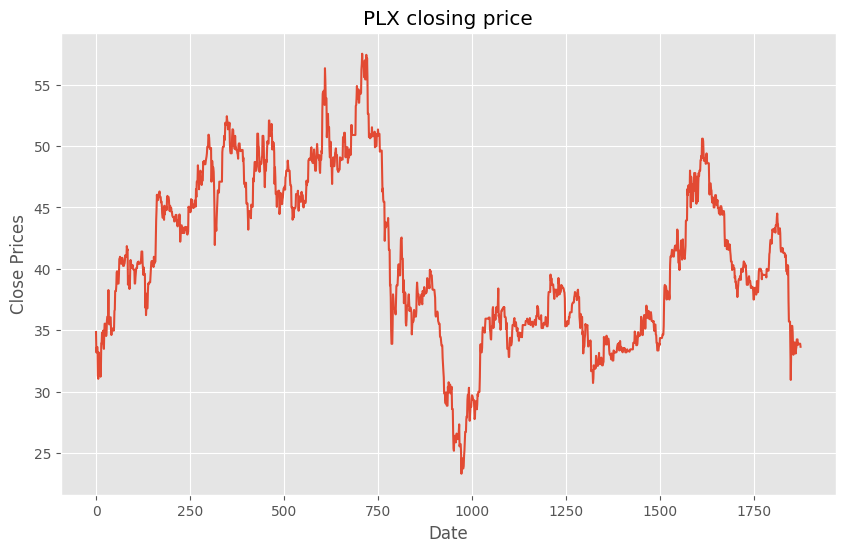

In [59]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['close'])
plt.title('PLX closing price')
plt.show()

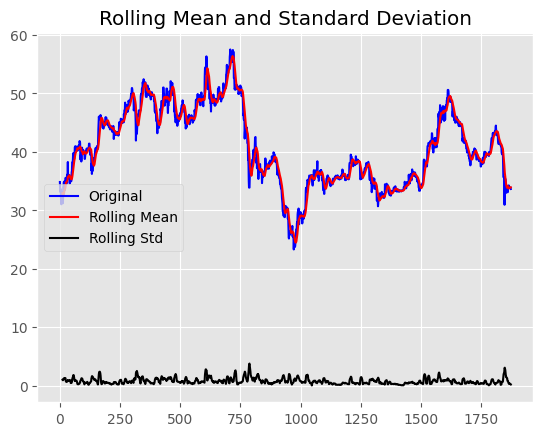

Results of dickey fuller test
Test Statistics                  -2.296028
p-value                           0.173252
No. of lags used                  7.000000
Number of observations used    1867.000000
critical value (1%)              -3.433857
critical value (5%)              -2.863089
critical value (10%)             -2.567595
dtype: float64


In [60]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

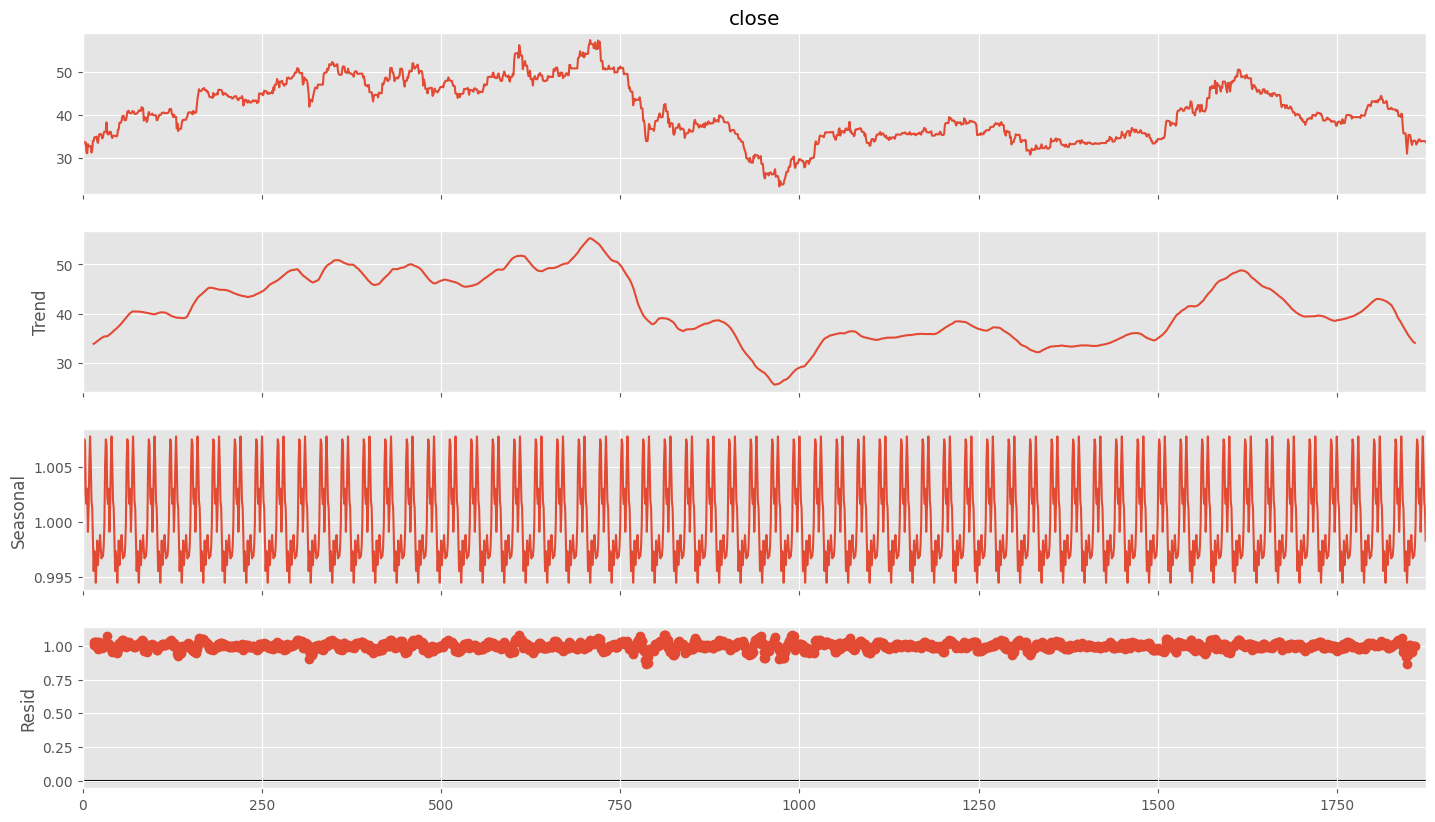

In [61]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period= 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

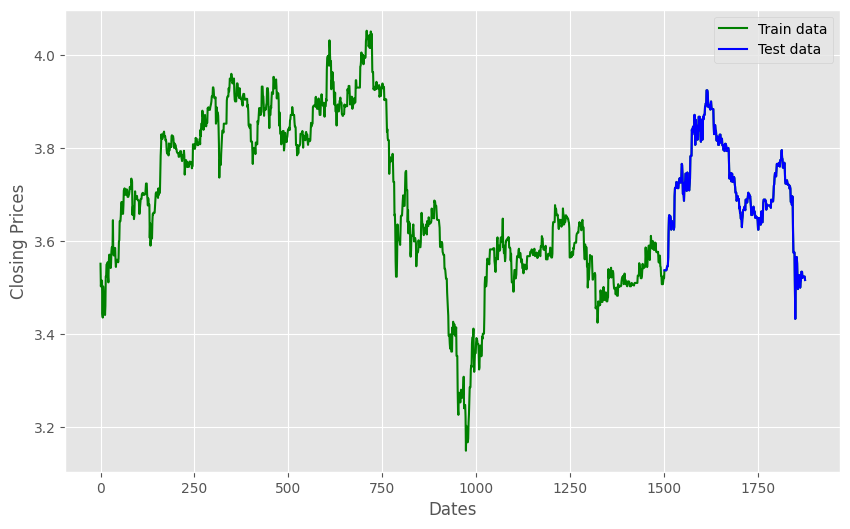

In [62]:
df_log = np.log(df_close)
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [63]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)
print(model_autoARIMA.summary())


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8029.555, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8027.810, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8027.306, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8026.682, Time=0.57 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8024.719, Time=1.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-8022.730, Time=1.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8027.793, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8025.583, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8026.644, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8028.551, Time=0.99 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8022.751, Time=1.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8027.552, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8029.058, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8024.830, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8021.804, Time=0.24

In [64]:
model = ARIMA(train_data, order=(2,0,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1497
Model:                 ARIMA(2, 0, 1)   Log Likelihood                4021.281
Date:                Fri, 06 Jun 2025   AIC                          -8032.562
Time:                        13:38:08   BIC                          -8006.006
Sample:                             0   HQIC                         -8022.668
                               - 1497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6485      0.093     39.069      0.000       3.465       3.832
ar.L1          0.0947      0.071      1.331      0.183      -0.045       0.234
ar.L2          0.8970      0.071     12.625      0.0

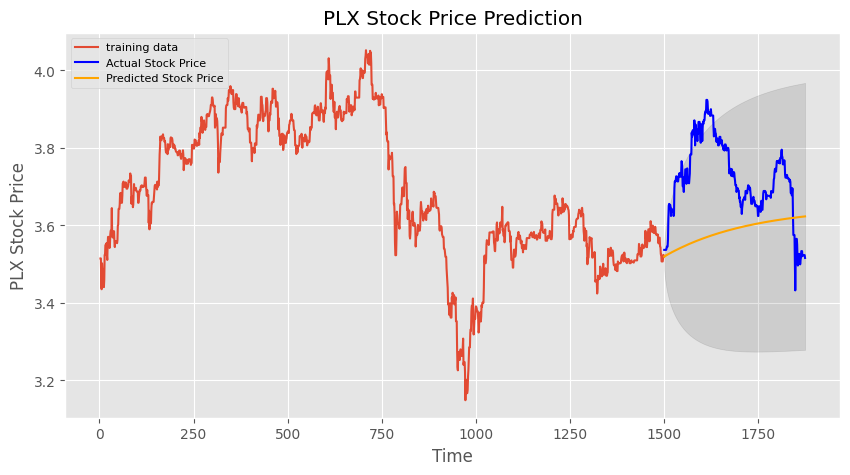

In [65]:
# Forecast with confidence intervals
n_periods = len(test_data)
forecast_res = fitted.get_forecast(steps=n_periods)
fc = forecast_res.predicted_mean
conf = forecast_res.conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('PLX Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('PLX Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [66]:
# report performance
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))

MSE: 48.8585698283322
MAE: 5.923593854346118
RMSE: 6.9898905448034165
MAPE: 0.1367232155838683
